# Stage 13 Homework — Productization

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## 1. Create mock, very basic analysis

In [7]:
import pandas as pd

# Tiny mock dataset
df = pd.DataFrame({
    "feature1": [1, 2, 3],
    "feature2": [4, 5, 6],
    "target":   [7, 8, 9]
})

print("Shape:", df.shape)
display(df.head())
display(df.describe())
print("Basic analysis complete.")

Shape: (3, 3)


,feature1,feature2,target
0,1,4,7
1,2,5,8
2,3,6,9


,feature1,feature2,target
count,3.0,3.0,3.0
mean,2.0,5.0,8.0
std,1.0,1.0,1.0
min,1.0,4.0,7.0
25%,1.5,4.5,7.5
50%,2.0,5.0,8.0
75%,2.5,5.5,8.5
max,3.0,6.0,9.0


Basic analysis complete.


## 2. Notebook Cleanup

In [1]:
# Keep only the cells you need + add comments where helpful.
print("Notebook cleaned and documented for handoff.")

Notebook cleaned and documented for handoff.


## 3. Move reusable functions to /src/

In [6]:
import sys
from pathlib import Path

ROOT = Path.cwd()
# If you're inside notebooks/, go up one level to the repo root
if not (ROOT / "src").exists():
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Using project root:", ROOT)
print("src exists?", (ROOT / "src").exists())

Using project root: /Users/ivysingal/bootcamp_ivy_singal
src exists? True


In [7]:
from src.utils import validate_numeric_list
print(validate_numeric_list([0.1, "2", 3]))

[0.1, 2.0, 3.0]


## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:
```
project/
  data/
  notebooks/
  src/
  reports/
  model/
  README.md
```
For API/Dashboard: minimal example:
```
project/
    app.py
    model.pkl
    requirements.txt
    README.md
```

## 5. Pickle / Save Final Model

In [8]:
from src.utils import SumModel
import pickle, os

os.makedirs("model", exist_ok=True)
with open("model/model.pkl","wb") as f:
    pickle.dump(SumModel(), f)

with open("model/model.pkl","rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded:", type(loaded_model).__name__)
print("Test prediction:", loaded_model.predict([[0.1, 0.2, 0.3]]))

Model loaded: SumModel
Test prediction: [0.6]


## 6. Flask API Starter

In [9]:
from flask import Flask, request, jsonify
import threading, io, base64, pickle
import matplotlib.pyplot as plt

# use the model saved in step 5
with open('model/model.pkl','rb') as f:
    loaded_model = pickle.load(f)

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(silent=True) or {}
    features = data.get('features')
    if features is None:
        return jsonify({'error': 'No features provided'}), 400
    try:
        pred = loaded_model.predict([features])
        pred_val = pred[0] if hasattr(pred, '__len__') else float(pred)
    except Exception:
        pred_val = sum(features)  # simple fallback
    return jsonify({'prediction': float(pred_val)})

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    try:
        pred = loaded_model.predict([[input1]])
        pred_val = pred[0] if hasattr(pred, '__len__') else float(pred)
    except Exception:
        pred_val = input1 * 2.0
    return jsonify({'prediction': float(pred_val)})

@app.route('/predict/<float:input1>/<float:input2>', methods=['GET'])
def predict_two(input1, input2):
    try:
        pred = loaded_model.predict([[input1, input2]])
        pred_val = pred[0] if hasattr(pred, '__len__') else float(pred)
    except Exception:
        pred_val = input1 + input2
    return jsonify({'prediction': float(pred_val)})

@app.route('/plot', methods=['GET'])
def plot():
    fig, ax = plt.subplots()
    ax.plot([0,1,2,3,4],[0,1,4,9,16])
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    import base64
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    return f"<img src='data:image/png;base64,{img_b64}'/>"

def run_flask():
    app.run(port=5000)

threading.Thread(target=run_flask, daemon=True).start()
print("Flask started at http://127.0.0.1:5000")

Flask started at http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Aug/2025 18:52:31] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 18:52:31] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 18:52:31] "GET /predict/1.0/3.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 18:52:31] "GET /plot HTTP/1.1" 200 -


## 7. Testing the Flask API from Notebook

{'prediction': 0.6000000000000001}
{'prediction': 2.0}
{'prediction': 4.0}



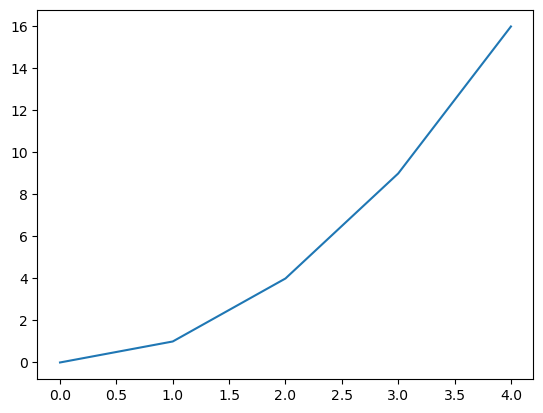

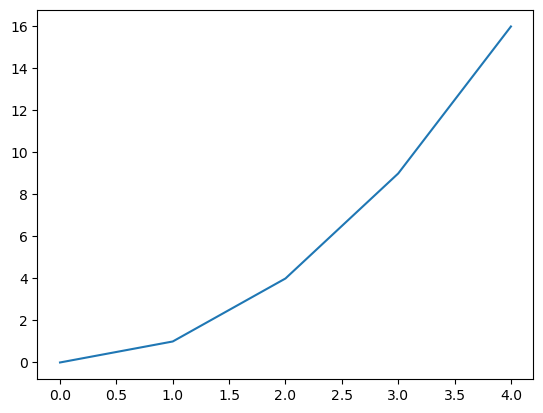

In [10]:
import requests
from IPython.display import display, HTML

# POST /predict
response = requests.post(
    "http://127.0.0.1:5000/predict",
    json={'features': [0.1, 0.2, 0.3]}
)
print(response.json())

# GET /predict/<input1>
resp2 = requests.get("http://127.0.0.1:5000/predict/2.0")
print(resp2.json())

# GET /predict/<input1>/<input2>
resp3 = requests.get("http://127.0.0.1:5000/predict/1.0/3.0")
print(resp3.json())

# GET /plot
resp_plot = requests.get("http://127.0.0.1:5000/plot")
display(HTML(resp_plot.text))